In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from LANAM.models import NAM, BayesianLinearRegression

from LANAM.config.default import defaults

from LANAM.trainer.training import *
from LANAM.trainer.marglik_training import *

from LANAM.data.generator import *
from LANAM.data.toydataset import ToyDataset

from LANAM.utils.plotting import * 

import matplotlib.pyplot as plt 
import numpy as np

"""
Reference:
@misc{kayid2020nams,
  title={Neural additive models Library},
  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},
  year={2020}
}
"""

'\nReference:\n@misc{kayid2020nams,\n  title={Neural additive models Library},\n  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},\n  year={2020}\n}\n'

In [2]:
%reload_ext autoreload 
%autoreload 2

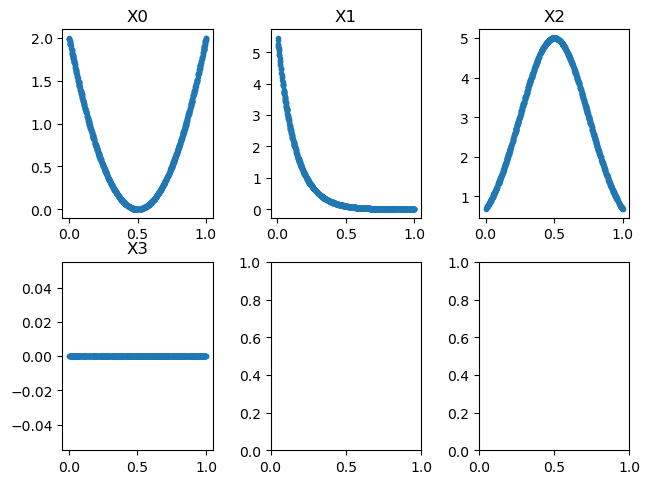

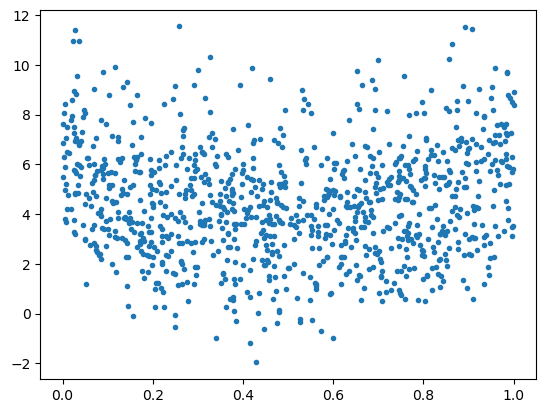

In [3]:
gen_funcs, gen_func_names = task()
sigma = 1.0
trainset = ToyDataset(gen_funcs,
                    gen_func_names, 
                    num_samples=1000, 
                    sigma=1.0)
valset = ToyDataset(gen_funcs,
                    gen_func_names, 
                    num_samples=200, 
                    sigma=1.0)
testset = ToyDataset(gen_funcs, 
                    gen_func_names, 
                    num_samples=50, 
                    use_test=True)
in_features = trainset.in_features
trainset.plot()

In [8]:
cfg = defaults()
model = NAM(
    config=cfg, 
    name="LANAM", 
    in_features=in_features, 
    hessian_structure='full')
model

NAM(
  feature_nns=ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=1, bias=True)
        (3): GELU(approximate='none')
      )
    )
  )
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=1, bias=True)
        (3): GELU(approximate='none')
      )
    )
  )
)

In [9]:
model, margliks, losses = marglik_training(model, trainset.loader, trainset.loader_fnn, 
                 'regression', n_epochs=200)

EPOCH=1: epoch_loss= 21.131
EPOCH=51: epoch_loss= 2.713
EPOCH=101: epoch_loss= 1.255
EPOCH=151: epoch_loss= 1.154
MARGLIK: finished training. Recover best model and fit Laplace.


In [10]:
print(model.prior_precision)
print(model.sigma_noise)

tensor([0.0624, 0.0322, 0.0316, 0.0962], grad_fn=<ExpBackward0>)
tensor([0.8277, 0.2579, 1.2330, 0.5844], grad_fn=<ExpBackward0>)


In [ ]:
f_mu, f_var, f_mu_fnn, f_var_fnn = model.predict(testset.X)
reg_noise = model.sigma_noise.reshape(1, -1, 1)
pred_var_fnn = f_var_fnn + reg_noise 
pred_var = f_var + reg_noise.sum()
predictive_samples = model.predictive_samples(testset.X) 
sample_noise = model.sigma_noise.reshape(1, 1, -1)
predictive_samples += sample_noise

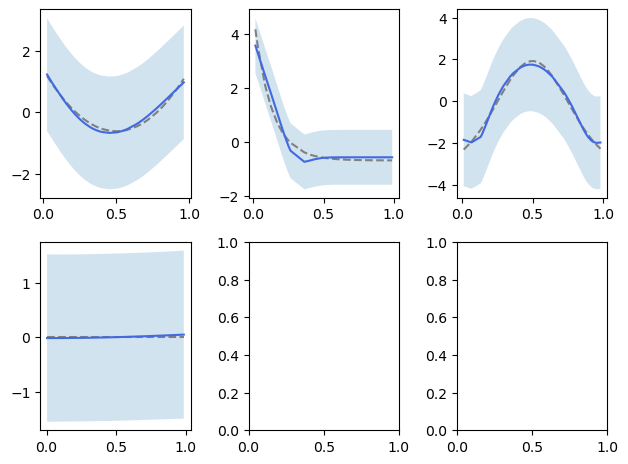

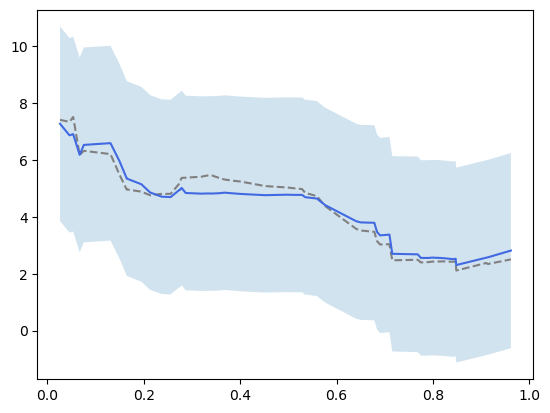

In [13]:
reg_predictive_plot(testset.X, 
                    testset.y, 
                    testset.fnn, 
                    f_mu, pred_var, f_mu_fnn, pred_var_fnn, 
                    predictive_samples=None,
                    plot_additive=True)

In [20]:
loss = train(cfg, model, trainset.loader, valset.loader)

=============EPOCH 1==============
loss_train:  8.771, loss_val:  4.859
=============EPOCH 101==============
loss_train:  1.116, loss_val:  1.060
Finished Training.


In [21]:
model.fit(trainset.loader_fnn)

In [7]:
# laplace-torch
n_epochs = 1000
log_prior, log_sigma = torch.ones(in_features, requires_grad=True), torch.ones(in_features, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - model.log_marginal_likelihood(log_prior.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [9]:
# laplace-torch
#n_epochs = 1000
#log_prior, log_sigma = torch.ones(in_features, requires_grad=True), torch.ones(in_features, requires_grad=True)
#hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
#for i in range(n_epochs):
#    hyper_optimizer.zero_grad()
#    neg_marglik = - model.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
#    neg_marglik.backward()
#    hyper_optimizer.step()

In [10]:
f_mu, f_var, f_mu_fnn, f_var_fnn = model.predict(testset.X)
reg_noise = model.sigma_noise.reshape(1, -1, 1)
pred_var_fnn = f_var_fnn + reg_noise 
pred_var = f_var + reg_noise.sum()

In [11]:
predictive_samples = model.predictive_samples(testset.X)
sample_noise = model.sigma_noise.reshape(1, 1, -1)
predictive_samples += sample_noise

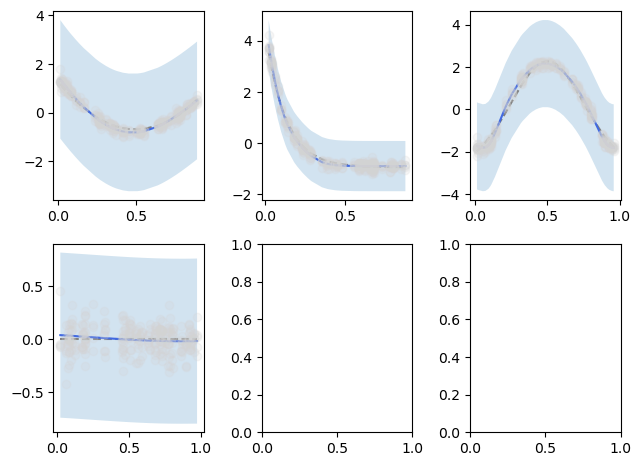

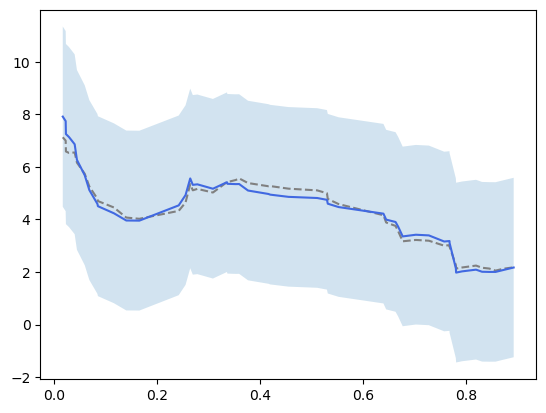

In [16]:
reg_predictive_plot(testset.X, 
                    testset.y, 
                    testset.fnn, 
                    f_mu, pred_var, f_mu_fnn, pred_var_fnn, 
                    predictive_samples, 
                    plot_additive=True)